## Data Exploration

In this notebook we shall perform initial EDA and work out a game plan to get our top 5 regions to invest in

In [1]:
import pandas as pd

#### Bring in the data

In [2]:
df = pd.read_csv('../../data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

#### that's way too many zipcodes to analyze **14723**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [6]:
df.isna().sum().head(20)

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
dtype: int64

Most of the Nan values in the time series appear to be in the intial time period in 1996 -1997 time frame

Trying to see if we can shortlist these entries based on ROI over 4, 8, 12, 16 year period(april of 4x years before 4/2018)

In [7]:
#df['roi_4years'] = ((df['2018-04'] - df['2014-04'])/df['2014-04'])*100
#df['roi_8years'] = ((df['2018-04'] - df['2010-04'])/df['2010-04'])*100
#df['roi_12years'] = ((df['2018-04'] - df['2006-04'])/df['2006-04'])*100
#df['roi_16years'] = ((df['2018-04'] - df['2002-04'])/df['2002-04'])*100

In [8]:
#df_rois = df.loc[:, ['roi_4years', 'roi_8years', 'roi_12years', 'roi_16years',
#           'RegionID', 'City', 'State', 'CountyName', 'SizeRank']]

In [9]:
#df_rois.isna().sum()

In [10]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

The first seven columns look like any other dataset. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. 

Below is the function to reshape from wide to long format

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City',
                                  'State', 'Metro', 'CountyName', 'RegionID', 'SizeRank'],
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [72]:
def melt_data_ROI(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City',
                                  'State', 'Metro', 'CountyName', 'RegionID', 'SizeRank', 'ROI_5yrs'],
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [12]:
melted_df = melt_data(df)

In [13]:
melted_df.head(5)

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
0,60657,Chicago,IL,Chicago,Cook,84654,1,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,90668,2,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,91982,3,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,84616,4,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,93144,5,1996-04-01,77300.0


In [14]:
melted_df.tail(5)

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
3901590,1338,Ashfield,MA,Greenfield Town,Franklin,58333,14719,2018-04-01,209300.0
3901591,3293,Woodstock,NH,Claremont,Grafton,59107,14720,2018-04-01,225800.0
3901592,40404,Berea,KY,Richmond,Madison,75672,14721,2018-04-01,133400.0
3901593,81225,Mount Crested Butte,CO,NaN,Gunnison,93733,14722,2018-04-01,664400.0
3901594,89155,Mesquite,NV,Las Vegas,Clark,95851,14723,2018-04-01,357200.0


In [15]:
melted_df.shape

(3744704, 9)

In [38]:
new_df = pd.DataFrame()
new_df['time'] = pd.date_range(start='1996-04-01', end='2018-04-01', freq='MS')

In [39]:
new_df

,time
0,1996-04-01
1,1996-05-01
2,1996-06-01
3,1996-07-01
4,1996-08-01
...,...
260,2017-12-01
261,2018-01-01
262,2018-02-01
263,2018-03-01


In [ ]:
#def add_home_median_values(row, df):
#if row.time == df.time:
#    new_df.value = row.value
    

Based on our group discuassion we have decided to narrow down the zipcodes to the **Chicago area**.


For our initial models and eda we have shortlisted the top 30 zipcodes based on their ROI in the last 5 years.

For now I'll be looking into these 10 (top 20through 30) Chicago zipcodes to get some sense of the data and run some Time Series Models.

In [65]:
df_chi_metro = df[df['Metro'] == 'Chicago']

In [66]:
df_chi_metro['ROI_5yrs'] = ((df_chi_metro['2018-04'] -df_chi_metro['2013-04'])/df_chi_metro['2013-04'])*100

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
df_chi_metro.sort_values('ROI_5yrs', ascending=False)[:30]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI_5yrs
948,84693,60804,Cicero,IL,Chicago,Cook,949,96500.0,97000.0,97300.0,...,155800,156800,157900,159200,160500,161800,162900,163800,164400,50.669100
383,84340,60085,Waukegan,IL,Chicago,Lake,384,96100.0,96700.0,97100.0,...,107100,107300,106800,107200,107600,108600,110800,113400,114500,45.502183
5896,84403,60153,Maywood,IL,Chicago,Cook,5897,88600.0,88400.0,88000.0,...,128200,130400,133500,136700,139200,142000,144100,144800,145500,44.673540
3337,84364,60110,Carpentersville,IL,Chicago,Kane,3338,112100.0,113100.0,113600.0,...,153200,154300,155200,156500,158100,159200,160100,161800,163200,44.301471
6727,84358,60104,Bellwood,IL,Chicago,Cook,6728,97900.0,98300.0,98600.0,...,139300,141000,142900,144200,145300,146700,148300,149800,150700,43.397478
1392,84541,60505,Aurora,IL,Chicago,Kane,1393,79300.0,80000.0,80200.0,...,118700,119500,120800,122900,125500,127600,129200,131100,132100,43.300530
1496,84648,60651,Chicago,IL,Chicago,Cook,1497,74700.0,75100.0,75400.0,...,136100,137300,139600,141800,142900,145200,148300,150300,150900,43.207422
725,84329,60073,Round Lake Beach,IL,Chicago,Lake,726,125200.0,126100.0,126600.0,...,139700,140400,141200,142300,143400,144600,146300,147700,148100,41.796084
6496,84487,60436,Joliet,IL,Chicago,Will,6497,78200.0,78300.0,78400.0,...,103600,105000,107000,109200,111200,112700,114100,116100,117700,39.932031
658,84639,60639,Chicago,IL,Chicago,Cook,659,111200.0,111900.0,112300.0,...,223100,222900,223300,224600,226100,228700,231400,232700,232600,39.681857


In [70]:
list(df_chi_metro.sort_values('ROI_5yrs', ascending=False)[20:30].RegionName)

[60612, 60164, 60501, 60131, 60162, 60409, 60123, 60647, 60632, 60622]

In [91]:
chicago_20_30 = pd.DataFrame()
chicago_20_30['time'] = pd.date_range(start='1996-04-01', end='2018-04-01', freq='MS')
chicago_20_30.set_index('time', inplace=True)
#new_df['60660'] = melted_df[melted_df['RegionName'] == 60660].value.values

In [92]:
regions = [60612, 60164, 60501, 60131, 60162, 60409, 60123, 60647, 60632, 60622]
for region in regions:
    chicago_20_30[region] = melted_df[melted_df['RegionName'] == region].value.values

In [73]:
#chicago_melted = melt_data_ROI(df_chi_metro)
#chicago_melted

In [93]:
chicago_20_30

,60612,60164,60501,60131,60162,60409,60123,60647,60632,60622
time,,,,,,,,,,
1996-04-01,100900.0,124400.0,108300.0,129100.0,120300.0,80900.0,131800.0,122700.0,99600.0,217000.0
1996-05-01,101400.0,124700.0,108100.0,129400.0,120000.0,81200.0,132500.0,122800.0,100100.0,216900.0
1996-06-01,101900.0,124700.0,107900.0,129500.0,119700.0,81500.0,132700.0,122800.0,100400.0,216900.0
1996-07-01,102300.0,124400.0,107600.0,129500.0,119300.0,81500.0,132400.0,122700.0,100400.0,216800.0
1996-08-01,102700.0,123900.0,107400.0,129200.0,119000.0,81400.0,131400.0,122400.0,100300.0,216800.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,355200.0,180400.0,160300.0,183300.0,170200.0,81800.0,177400.0,470600.0,164300.0,816300.0
2018-01-01,353400.0,181300.0,162500.0,184400.0,171700.0,82600.0,178300.0,474500.0,164700.0,819300.0
2018-02-01,352300.0,182100.0,163800.0,186300.0,172800.0,83000.0,179300.0,475100.0,165200.0,819700.0


In [114]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

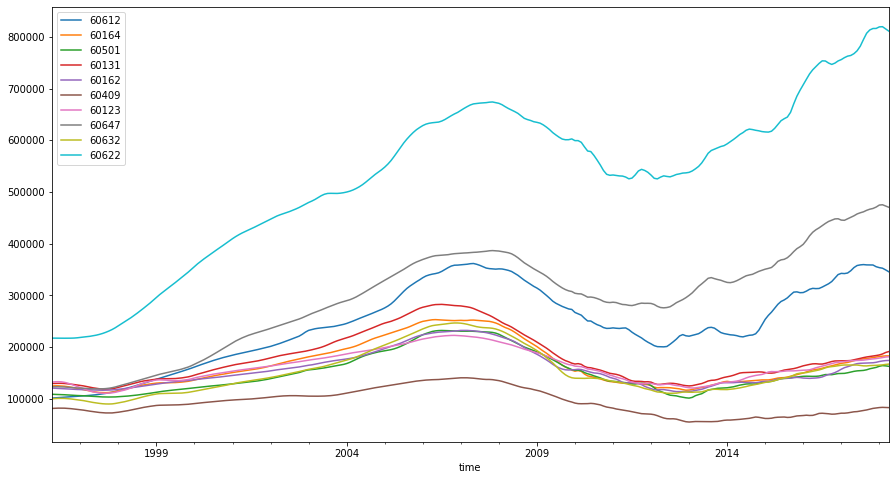

In [94]:
chicago_20_30.plot(figsize=(15,8));

In [86]:
all_regions = list(df_chi_metro.sort_values('ROI_5yrs', ascending=False)[0:30].RegionName)

In [87]:
top_30_df = pd.DataFrame()
top_30_df['time'] = pd.date_range(start='1996-04-01', end='2018-04-01', freq='MS')
top_30_df.set_index('time', inplace=True)
all_regions = list(df_chi_metro.sort_values('ROI_5yrs', ascending=False)[0:30].RegionName)
for region in all_regions:
    top_30_df[region] = melted_df[melted_df['RegionName'] == region].value.values

In [88]:
top_30_df

,60804,60085,60153,60110,60104,60505,60651,60073,60436,60639,...,60612,60164,60501,60131,60162,60409,60123,60647,60632,60622
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,96500.0,96100.0,88600.0,112100.0,97900.0,79300.0,74700.0,125200.0,78200.0,111200.0,...,100900.0,124400.0,108300.0,129100.0,120300.0,80900.0,131800.0,122700.0,99600.0,217000.0
1996-05-01,97000.0,96700.0,88400.0,113100.0,98300.0,80000.0,75100.0,126100.0,78300.0,111900.0,...,101400.0,124700.0,108100.0,129400.0,120000.0,81200.0,132500.0,122800.0,100100.0,216900.0
1996-06-01,97300.0,97100.0,88000.0,113600.0,98600.0,80200.0,75400.0,126600.0,78400.0,112300.0,...,101900.0,124700.0,107900.0,129500.0,119700.0,81500.0,132700.0,122800.0,100400.0,216900.0
1996-07-01,97300.0,97300.0,87600.0,113600.0,98700.0,80100.0,75600.0,126700.0,78500.0,112500.0,...,102300.0,124400.0,107600.0,129500.0,119300.0,81500.0,132400.0,122700.0,100400.0,216800.0
1996-08-01,97100.0,97200.0,86900.0,113100.0,98500.0,79700.0,75600.0,126400.0,78600.0,112500.0,...,102700.0,123900.0,107400.0,129200.0,119000.0,81400.0,131400.0,122400.0,100300.0,216800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,160500.0,107600.0,139200.0,158100.0,145300.0,125500.0,142900.0,143400.0,111200.0,226100.0,...,355200.0,180400.0,160300.0,183300.0,170200.0,81800.0,177400.0,470600.0,164300.0,816300.0
2018-01-01,161800.0,108600.0,142000.0,159200.0,146700.0,127600.0,145200.0,144600.0,112700.0,228700.0,...,353400.0,181300.0,162500.0,184400.0,171700.0,82600.0,178300.0,474500.0,164700.0,819300.0
2018-02-01,162900.0,110800.0,144100.0,160100.0,148300.0,129200.0,148300.0,146300.0,114100.0,231400.0,...,352300.0,182100.0,163800.0,186300.0,172800.0,83000.0,179300.0,475100.0,165200.0,819700.0


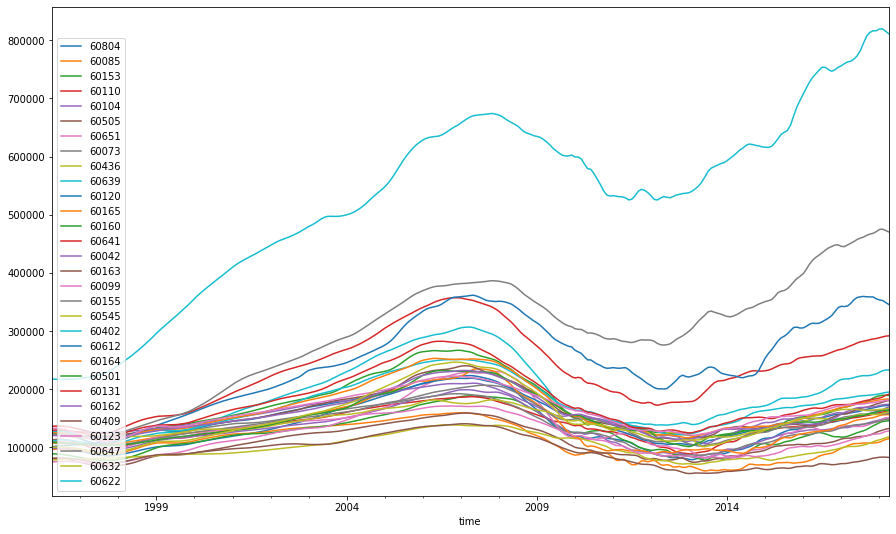

In [98]:
top_30_df.plot(figsize=(15,9))
plt.legend(loc='lower left');

In [101]:
chicago_20_30.isna().sum().sum()

0

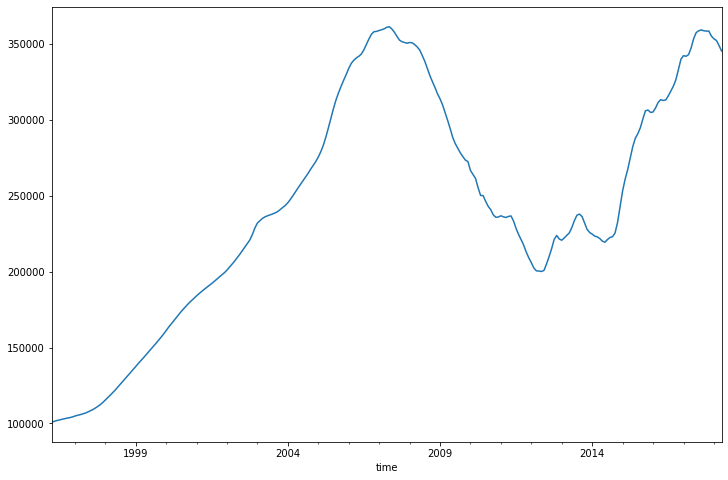

In [105]:
chicago_20_30.loc[:, 60612].plot(figsize=(12,8));

In [110]:
model = sm.tsa.statespace.SARIMAX(chicago_20_30.loc[:, 60612],
                                  order=(1,1,1),
                                  enforce_stationarity=False,
                                 enforce_invertibility=False)
output = model.fit()
output.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60612   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2237.450
Date:                Mon, 27 Jul 2020   AIC                           4480.900
Time:                        12:24:49   BIC                           4491.605
Sample:                    04-01-1996   HQIC                          4485.202
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8480      0.031     27.508      0.000       0.788       0.908
ma.L1          0.3525      0.029     12.242      0.000       0.296       0.409
sigma2      1.529e+06   8.15e+04     18.763      0.000    1.37e+06    1.69e+06
===================================================================================
Ljung-Box (Q):                      114.34   Jarque-Bera (JB):               187.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.00   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

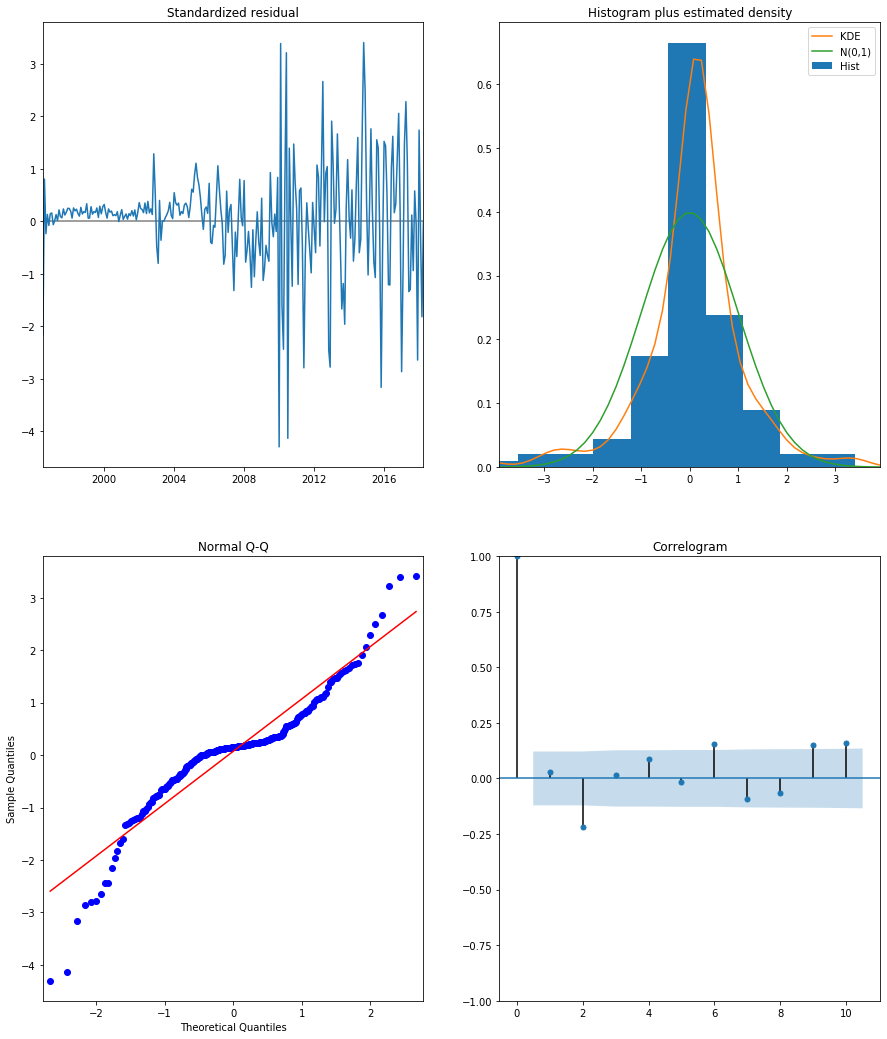

In [111]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [119]:
pred = output.get_prediction(start=pd.to_datetime('2014-7-01'), dynamic=False)
pred_conf = pred.conf_int()

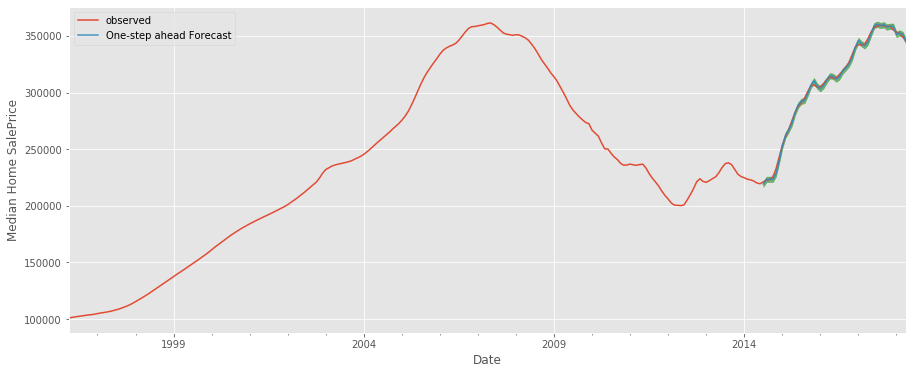

In [120]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = chicago_20_30.loc[:, 60612].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home SalePrice')
plt.legend()

plt.show()

In [123]:
pred = output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=True, full_results=True)
pred_conf = pred.conf_int()

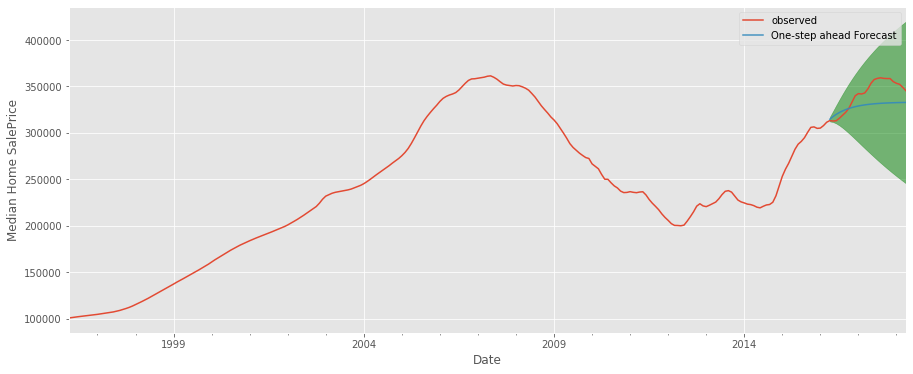

In [124]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = chicago_20_30.loc[:, 60612].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home SalePrice')
plt.legend()

plt.show()

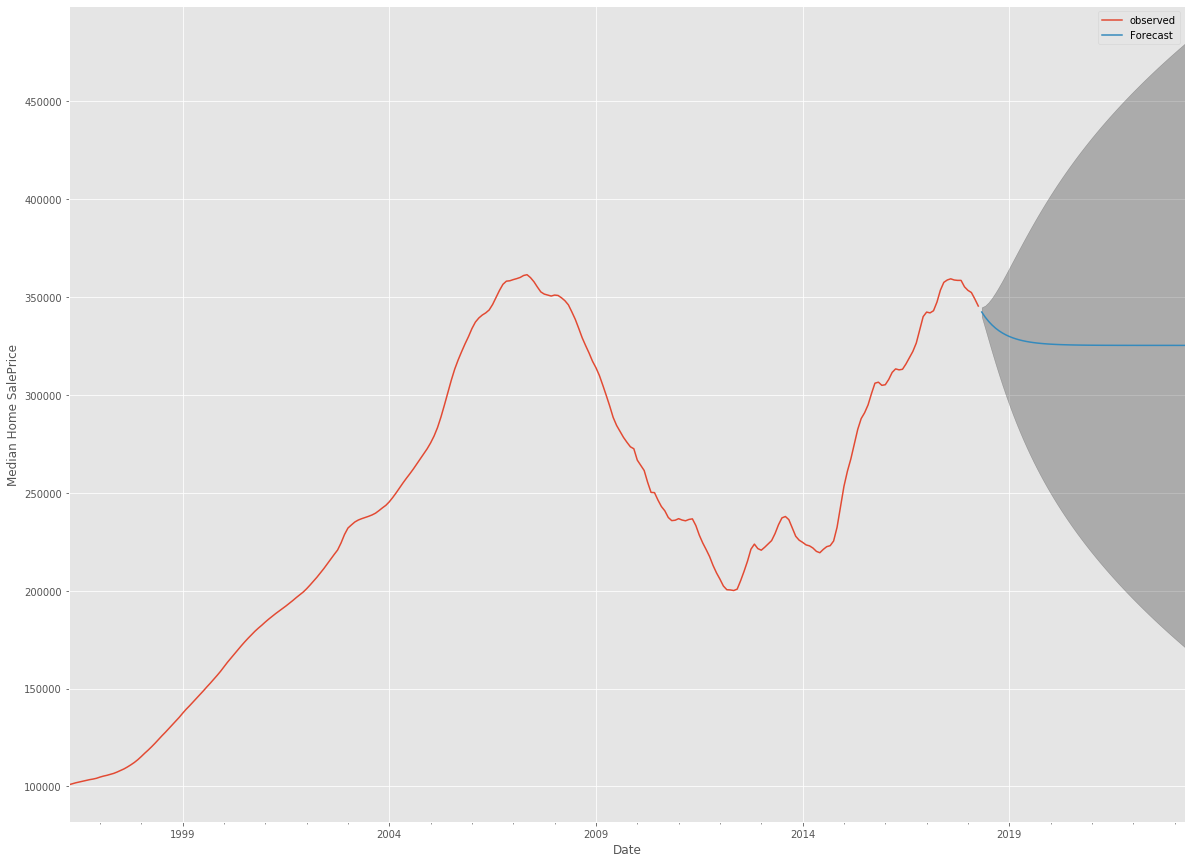

In [125]:
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
ax = chicago_20_30.loc[:, 60612].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home SalePrice')

plt.legend()
plt.show()